In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import DenseNet201_Weights
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import os
from os import path
import datetime

In [20]:
print(torch.cuda.is_available())
print(torch.__version__)

False
2.1.0+cpu


In [21]:
input_dataset = '12_11_2023_14_30_39'

In [22]:
def dataset_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'data', f'{os.path.basename(abs_path)}', timestamp)

In [23]:
dataset_path(input_dataset)

'C:\\Users\\chris\\Documents\\GitHub\\tensionterminator\\data\\alternative_tool_finder\\12_11_2023_14_30_39'

In [24]:
# Data transformations
transforms_wt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

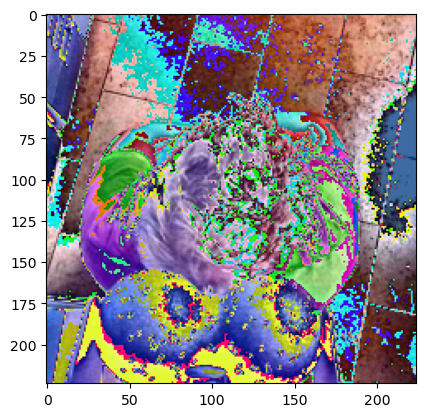

In [25]:
orig_set = datasets.ImageFolder(
    root=dataset_path(input_dataset),
    transform=transforms_wt
)
data, label = orig_set[100]
transform_test = T.ToPILImage()
plt.imshow(transform_test(data))

In [26]:
orig_set.classes
len(orig_set)

4843

In [27]:
data, label = orig_set[0]
print(data.size())

torch.Size([3, 224, 224])


In [28]:
import torch
from torch.utils.data import random_split, DataLoader

data_loader = DataLoader(orig_set, batch_size=len(orig_set), shuffle=True)

# Define the dataset size
dataset_size = len(orig_set)

# Calculate the sizes for training, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(orig_set, [train_size, val_size, test_size])

In [29]:
val_data, val_label = val_set[1]
print(val_data.size())

torch.Size([3, 224, 224])


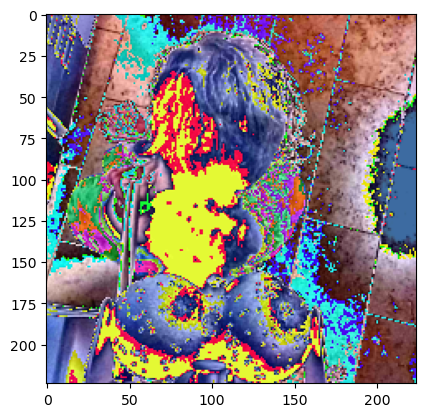

In [30]:
transform = T.ToPILImage()
plt.imshow(transform(val_data))

In [31]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [32]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [33]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [34]:
# Load DenseNet model
model = models.densenet201(weights=DenseNet201_Weights.IMAGENET1K_V1)  # You can choose a different variant if needed


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\chris/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:41<00:00, 1.97MB/s]


In [35]:
# Adjust classifier layers
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 2)
)


In [36]:
# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [37]:
#usage of framework to train and document
import sys
sys.path.append('C:/Users/chris/Documents/GitHub/tensionterminator/')
from framework.frameworktest_pyt import FrameworkLogger
from framework.main_func import main_train_func

input_args = [train_loader, val_loader, model, criterion, optimizer, exp_lr_scheduler, device]

# Modell trainieren
logger = FrameworkLogger(5, model, main_train_func, input_args, "christina_pytorch")
logger.train_model()
#logger.generate_statistics()


Epoch 0
Epoch: 0: Train: Loss: 0.0228 Acc: 0.9478 Val: Loss: 0.0940 Acc: 0.9711
{'loss': 0.022791187039684004, 'accuracy': 0.9478021860122681, 'val_loss': 0.09403915033883896, 'val_accuracy': 0.9710743801652892}
Epoch 0 took 981.49 seconds
Epoch 1
Epoch: 1: Train: Loss: 0.0391 Acc: 0.9148 Val: Loss: 0.0069 Acc: 0.9886
{'loss': 0.039096653456599934, 'accuracy': 0.9148351550102234, 'val_loss': 0.006873366566209321, 'val_accuracy': 0.9886363636363636}
Epoch 1 took 998.17 seconds
Epoch 2
Epoch: 2: Train: Loss: 0.0099 Acc: 0.9852 Val: Loss: 0.0128 Acc: 0.9711
{'loss': 0.009880532614791203, 'accuracy': 0.9852335453033447, 'val_loss': 0.012758028156639746, 'val_accuracy': 0.9710743801652892}
Epoch 2 took 939.18 seconds
Epoch 3
Epoch: 3: Train: Loss: 0.0117 Acc: 0.9746 Val: Loss: 2.4202 Acc: 0.7448
{'loss': 0.011743312330427413, 'accuracy': 0.9745879173278809, 'val_loss': 2.4202249369406994, 'val_accuracy': 0.7448347107438017}
Epoch 3 took 938.82 seconds
Epoch 4
Epoch: 4: Train: Loss: 0.1209 A

In [38]:
def get_time():
    return datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

In [39]:
def model_save_path(timestamp: str):
    abs_path = os.getcwd()
    two_up =  path.abspath(path.join(abs_path ,"../.."))
    return path.join(two_up, 'models', f'{os.path.basename(abs_path)}', timestamp, f'model_{get_time()}.pt')


In [40]:
model_save_path(input_dataset)

'C:\\Users\\chris\\Documents\\GitHub\\tensionterminator\\models\\alternative_tool_finder\\12_11_2023_14_30_39\\model_18_11_2023_22_20_40.pt'

In [41]:
save_path = model_save_path(input_dataset)

os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(model.state_dict(), save_path)

In [42]:
# Test the model
num_correct = 0.0
for inputs, labels in test_loader:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    predict_label = model(inputs)
    _, predicted = torch.max(predict_label,1)
    num_correct += (predicted == labels).float().sum()

    accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

print(len(test_loader), test_loader.batch_size)
print("Test Accuracy: {}".format(accuracy))

122 8
Test Accuracy: 0.993852436542511


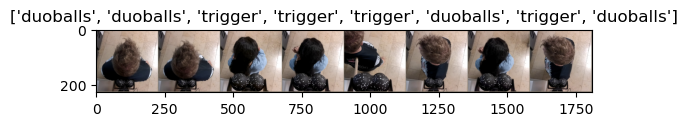

In [43]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def print_grid():
    inputs, classes = next(iter(test_loader))
    out = torchvision.utils.make_grid(inputs)
    class_names = orig_set.classes

    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)

    imshow(out, title=[class_names[x] for x in preds])

print_grid()